In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scienceplots
import time

from util import DHO_Dataset
from util import SimpleNetwork, PhysicsInformedNN
from util import plot_loss

plt.style.use(['science', 'ieee'])
torch.manual_seed(1024)
np.random.seed(1024)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.device(device)

# Model settings
supervised = True
if supervised == True:
    model_name = f"supervised_pinn"
else:
    model_name = f"unsupervised_pinn"
num_epochs = 200_000
learning_rate = 1e-3
patience = 100  # Number of epochs to wait for loss improvement

# Parameters
k_values = [100, 200, 300, 400, 500] # spring constant (N/m)
c_values = [2, 4, 6, 8, 10] # damping constant (N.s/m)
m_values = [0.5, 1.0, 1.5, 2.0, 2.5] # load mass (kg)
t_range = (0.0, 1.0) # time domin (sec)
num_samples = 100
num_train_sets = 5  # Number of training sets to generate
test_set = (500, 10, 2.5)

In [7]:
dataset = DHO_Dataset(k_values, c_values, m_values, t_range, num_samples)
training_sets = dataset.generate_training_sets(5)
test_dataset = dataset.generate_testing_set(*test_set)
features, labels = dataset.PreprocessData(training_sets)
features_tensor, labels_tensor = dataset.CreateTensor(features, labels, device)
test_features, test_labels = dataset.PreprocessData(test_dataset)
test_features_tensor, test_labels_tensor = dataset.CreateTensor(test_features, test_labels, device)

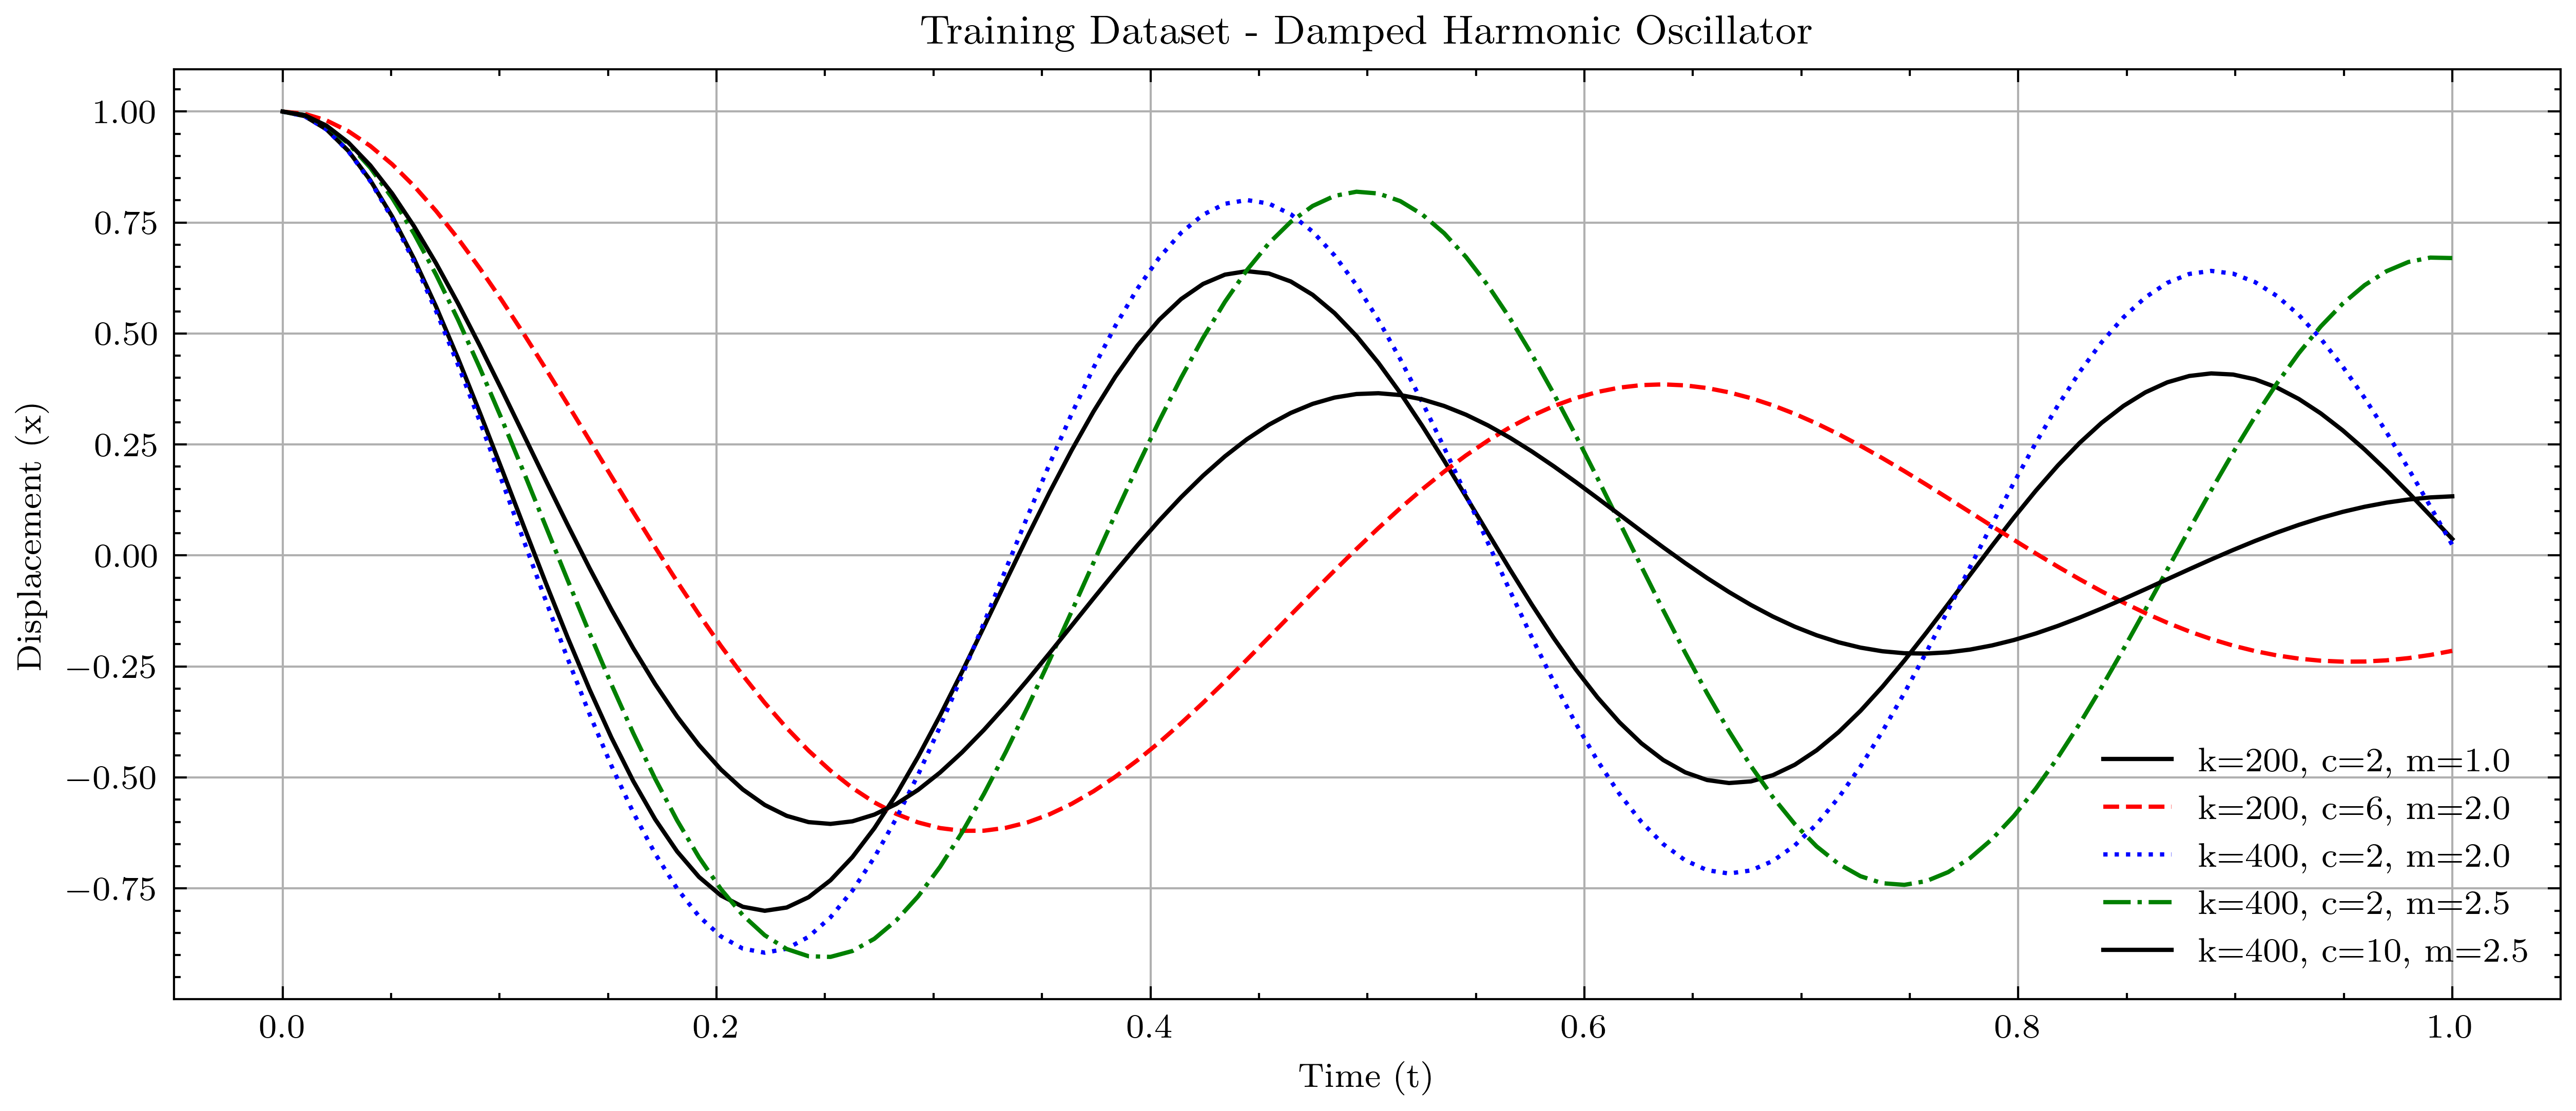

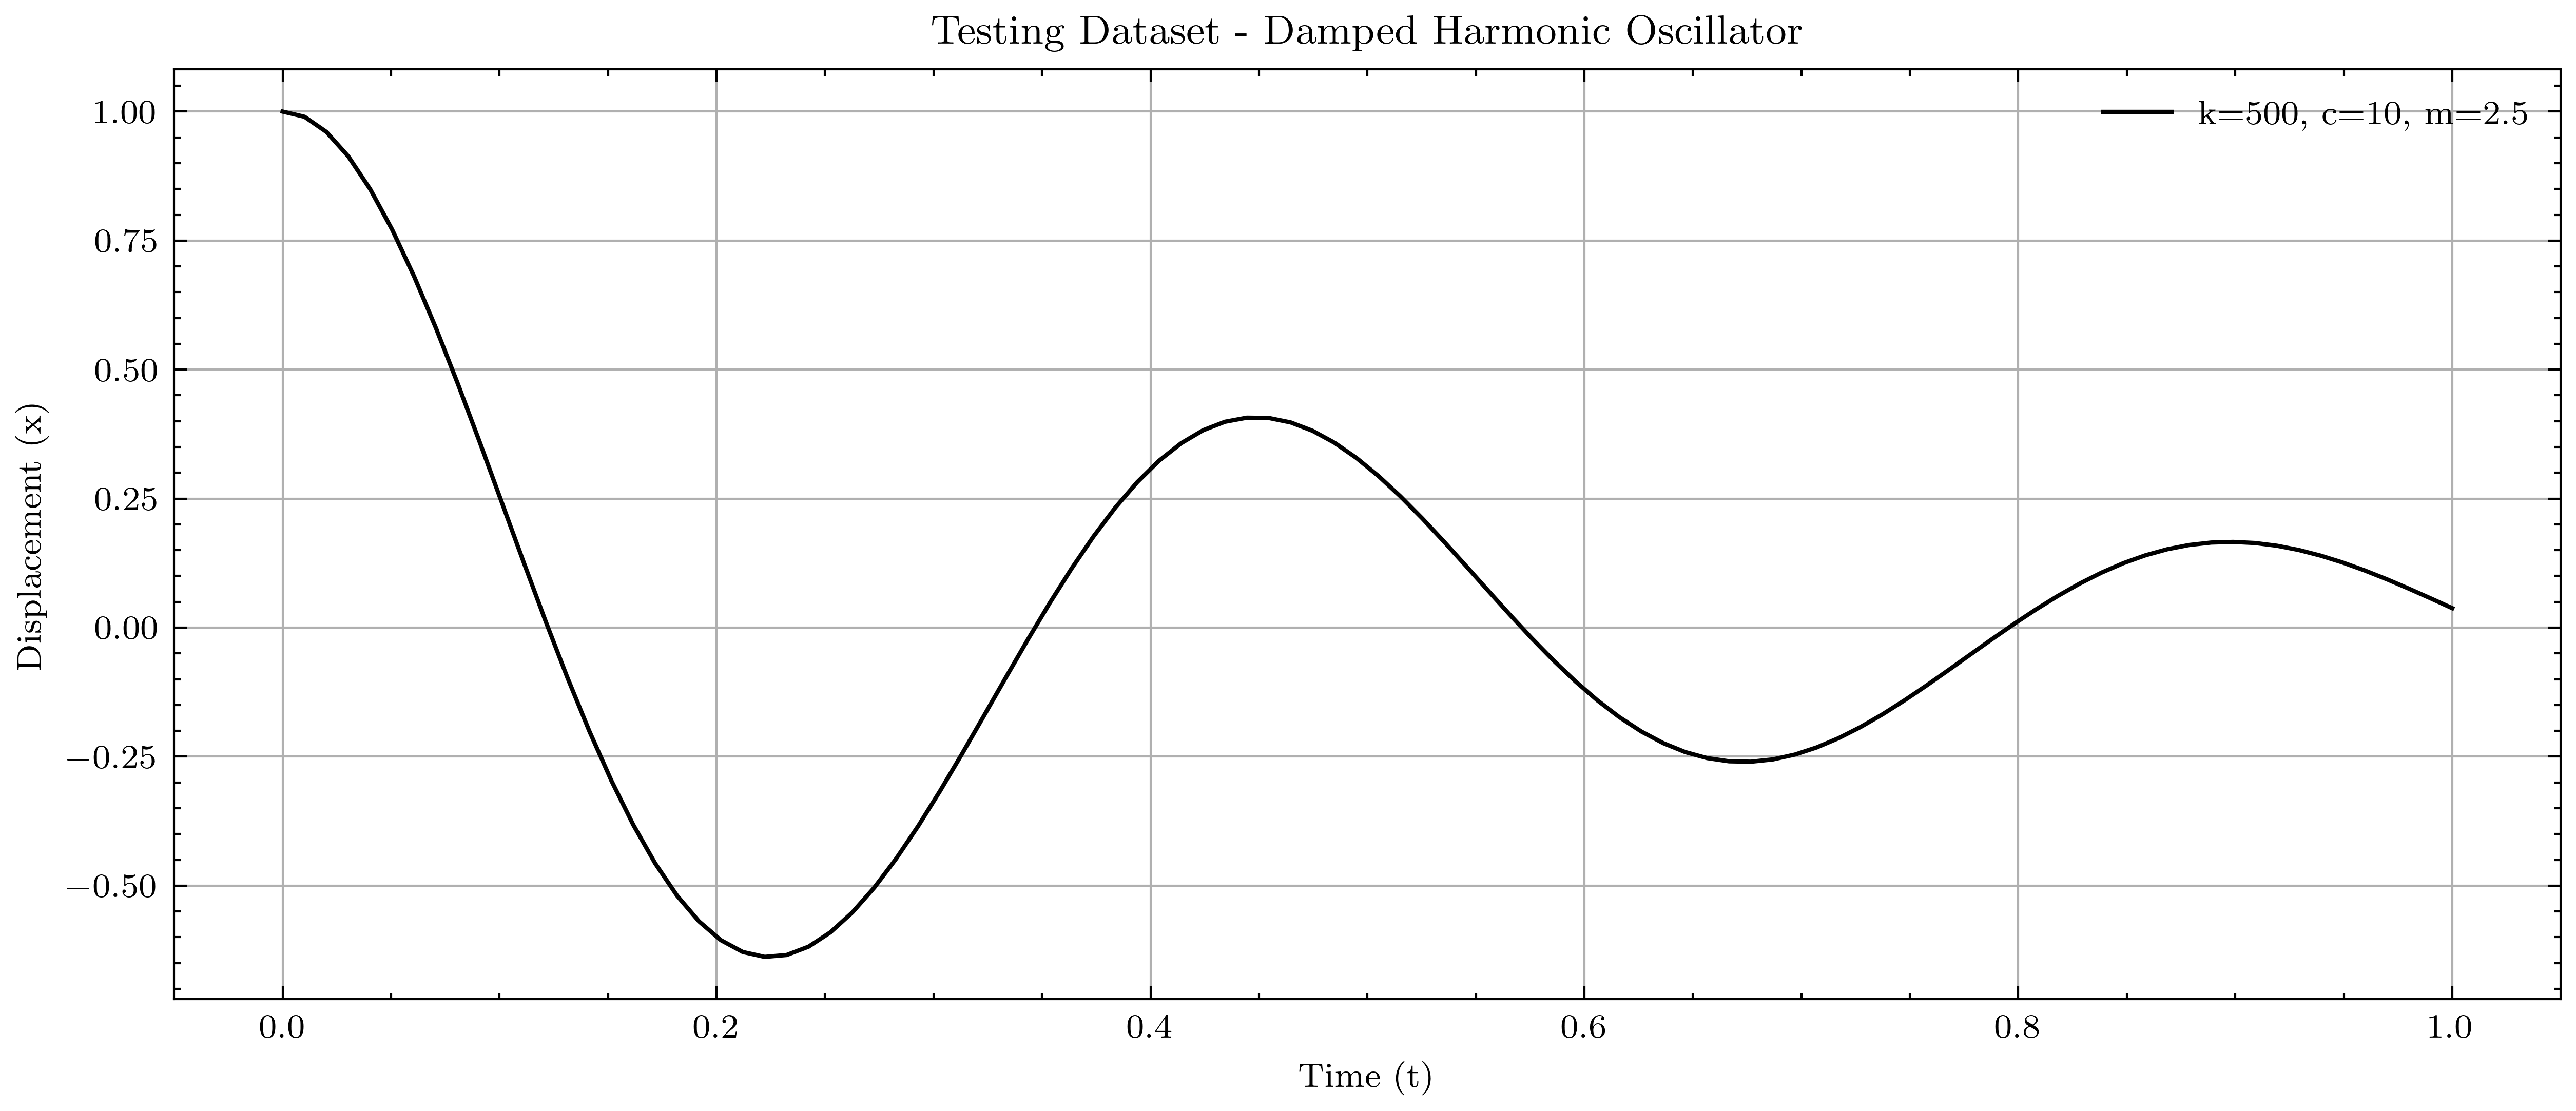

In [8]:
dataset.plot_training_dataset(training_sets)
dataset.plot_testing_dataset(test_dataset)

In [9]:
# Create the neural network model and instantiate the PhysicsInformedNN class
model = SimpleNetwork(4, 1, 32, 8).to(device)
physics_nn = PhysicsInformedNN(model, supervised=supervised)

# Measure execution time for training and evaluation
start_time = time.time()
loss_log, test_loss = physics_nn.train_and_evaluate(
    features_tensor, labels_tensor, test_features_tensor, test_labels_tensor,
    num_epochs, learning_rate, evaluation_interval=100, patience=patience)

end_time = time.time()

# Calculate and print the execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Epoch [100/200000], Loss: 0.1142, Test Loss: 0.0631
Epoch [200/200000], Loss: 0.0549, Test Loss: 0.0722
Epoch [300/200000], Loss: 0.0077, Test Loss: 0.1213
Epoch [400/200000], Loss: 0.0050, Test Loss: 0.1276
Epoch [500/200000], Loss: 0.0040, Test Loss: 0.1327
Epoch [600/200000], Loss: 0.0028, Test Loss: 0.1363
Epoch [700/200000], Loss: 0.0014, Test Loss: 0.1404
Epoch [800/200000], Loss: 0.0004, Test Loss: 0.1419
Epoch [900/200000], Loss: 0.0002, Test Loss: 0.1438
Epoch [1000/200000], Loss: 0.0002, Test Loss: 0.1466
Epoch [1100/200000], Loss: 0.0002, Test Loss: 0.1472
Epoch [1200/200000], Loss: 0.0004, Test Loss: 0.1501
Epoch [1300/200000], Loss: 0.0001, Test Loss: 0.1485
Epoch [1400/200000], Loss: 0.0001, Test Loss: 0.1484
Epoch [1500/200000], Loss: 0.0001, Test Loss: 0.1497
Epoch [1600/200000], Loss: 0.0001, Test Loss: 0.1496
Epoch [1700/200000], Loss: 0.0007, Test Loss: 0.1524
Epoch [1800/200000], Loss: 0.0001, Test Loss: 0.1498
Epoch [1900/200000], Loss: 0.0001, Test Loss: 0.1505
Ep

Testing Loss: 0.1483
Training Loss: 0.0000


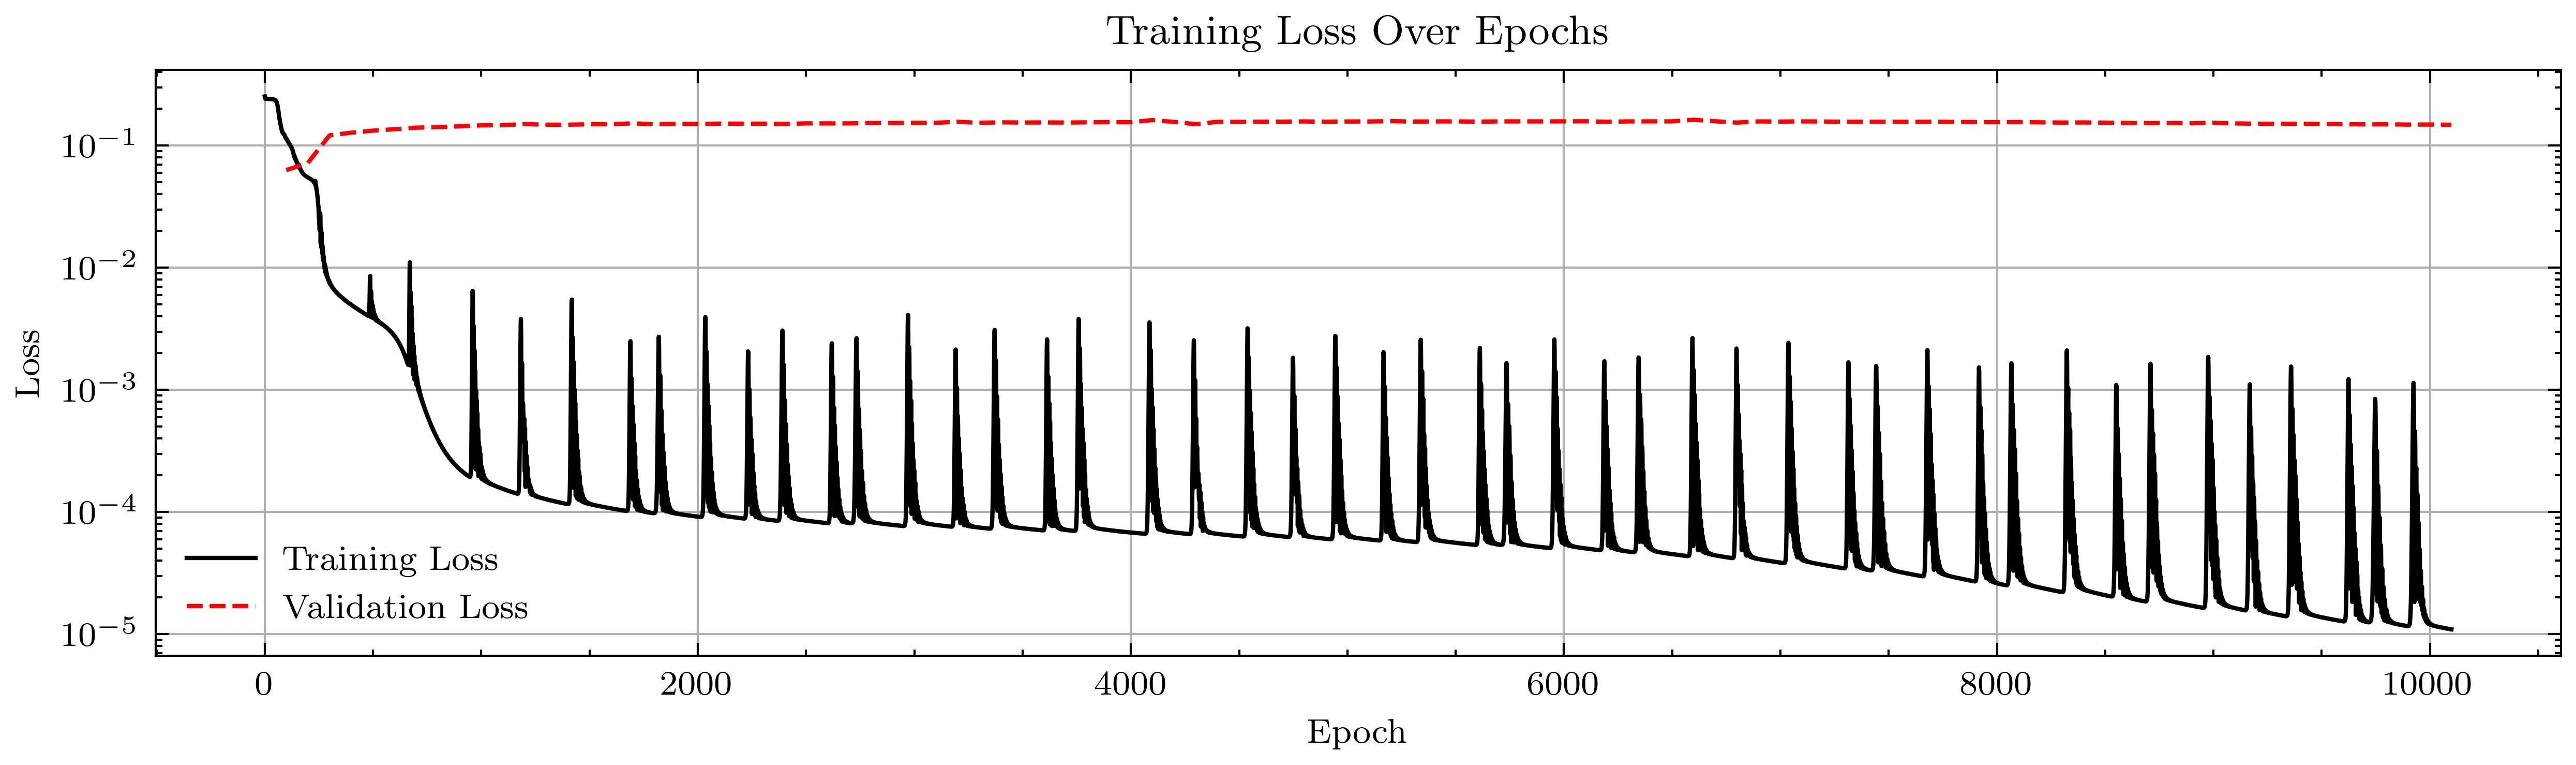

In [10]:
print(f"Testing Loss: {test_loss['loss'][-1]:.4f}")
print(f"Training Loss: {loss_log['loss'][-1]:.4f}")
plot_loss(loss_log, test_loss)